In [1]:
# Referred https://foolbox.jonasrauber.de/guide/examples.html
# and https://github.com/jonasrauber/foolbox-native-tutorial/blob/master/foolbox-native-tutorial.ipynb

In [2]:
import torchvision.models as models
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfFastGradientAttack, LinfPGD, BoundaryAttack #FGSM, PGD, Boundary Attack
from foolbox.criteria import Misclassification #untargeted attack criteria
import time
import foolbox as fb

In [3]:
model = models.resnet18(pretrained=True).eval()
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3) # mean and std for imagenet
fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)

/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
images, labels = ep.astensors(*samples(fmodel, dataset="imagenet", batchsize=16)) #imagenet has 1000 classes

In [5]:
labels

PyTorchTensor(tensor([243, 559, 438, 990, 949, 853, 609, 609, 915, 455, 541, 630, 741, 471,
                      129,  99]))

In [6]:
clean_acc = accuracy(fmodel, images, labels)
print(f"clean accuracy:  {clean_acc * 100:.1f} %")

clean accuracy:  93.8 %


In [7]:
# linf norm
eps = 0.01

In [8]:
attack_fgsm = LinfFastGradientAttack()
attack_pgd = LinfPGD()
attack_boundary = BoundaryAttack()

In [9]:
start = time.time()
fgsm_raw_advs, fgsm_clipped_advs, fgsm_success = attack_fgsm(fmodel, images, labels, epsilons=eps)
print(f"FGSM attack completed in {time.time()-start}s")

FGSM attack completed in 1.8313438892364502s


In [10]:
start = time.time()
pgd_raw_advs, pgd_clipped_advs, pgd_success = attack_pgd(fmodel, images, labels, epsilons=eps)
print(f"PGD attack completed in {time.time()-start}s")

PGD attack completed in 50.80701398849487s


In [11]:
start = time.time()
# foolbox.attacks.BoundaryAttack(init_attack=None, steps=25000, spherical_step=0.01, source_step=0.01, source_step_convergance=1e-07, step_adaptation=1.5, tensorboard=False, update_stats_every_k=10)
boundary_raw_advs, boundary_clipped_advs, boundary_success = attack_boundary(fmodel, images, labels, epsilons=eps)
print(f"Boundary attack completed in {time.time()-start}s")

Boundary attack completed in 15390.649468183517s


In [12]:
print(f"Accuracy after FGSM attack: {1 - fgsm_success.float32().mean(axis=-1)}")

Accuracy after FGSM attack: 0.0


In [13]:
print(f"Accuracy after PGD attack: {1 - pgd_success.float32().mean(axis=-1)}")

Accuracy after PGD attack: 0.0


In [14]:
print(f"Accuracy after boundary attack: {1 - boundary_success.float32().mean(axis=-1)}")

Accuracy after boundary attack: 0.9375


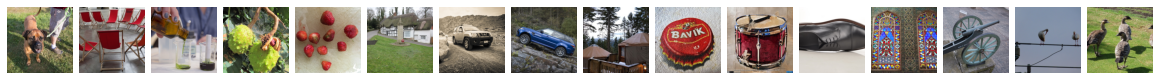

In [15]:
# Natural Images
fb.plot.images(images)

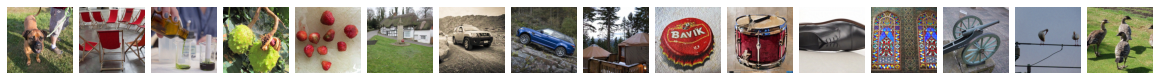

In [16]:
# Images after FGSM attack
fb.plot.images(fgsm_raw_advs)

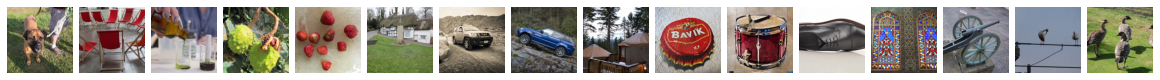

In [17]:
# Images after PGD attack
fb.plot.images(pgd_raw_advs)

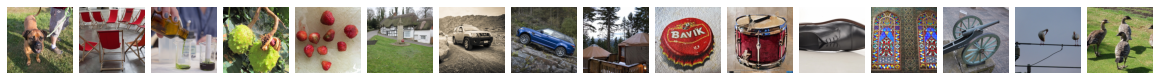

In [18]:
# Images after Boundary attack
fb.plot.images(boundary_raw_advs)